In [1]:
import numpy as np
import skimage.draw
import skimage.data
import skimage.transform
import matplotlib.pyplot as plt

In [2]:
def generate_phantom(image_size, n_shapes, min_size, max_size, pad=8, seed=None):
    '''
    Generate random stiffness and texture images.
    '''
    np.random.seed(seed)

    n_textures = 4
    texture_map = np.random.permutation(n_textures)
    texture_sources = [
        skimage.transform.resize(skimage.data.grass(), image_size),
        skimage.transform.resize(skimage.data.brick(), image_size),
        skimage.transform.resize(skimage.data.gravel(), image_size),
        skimage.transform.resize(skimage.data.text(), image_size)
    ]

    stiffness_map = np.random.permutation(4)
    stiffness_values = [2e3, 4e3, 8e3, 16e3]
    background_stiffness = 1e3

    redraw_shapes = True
    while redraw_shapes:
        print('\ndrawing random shapes')
        image, labels = skimage.draw.random_shapes(
            image_shape=image_size,
            min_shapes=n_shapes,
            max_shapes=n_shapes,
            min_size=min_size,
            max_size=max_size,
            channel_axis=None,
            intensity_range=(1, n_textures),
            allow_overlap=False,
            rng=seed
        )
        redraw_shapes = False
        if len(labels) < n_shapes:
            redraw_shapes = True
        for i, (category, bbox) in enumerate(labels):
            print(category, bbox)
            if category == 'triangle':
                redraw_shapes = True
            elif check_boundary_overlap(bbox, image_size, pad):
                redraw_shapes = True
            for j in range(i + 1, len(labels)):
                if check_bbox_overlap(bbox, labels[j][1], pad):
                    redraw_shapes = True

    # set background value to 0
    image = np.where(image == 255, 0, image)

    # assign textures
    texture_image = np.zeros_like(image)
    for i in range(n_textures):
        texture_source = texture_sources[texture_map[i]]
        texture_image = np.where(image == i + 1, texture_source, texture_image)

    # assign stiffness
    stiffness_image = np.ones_like(image) * background_stiffness
    for i in range(n_textures):
        stiffness_value = stiffness_values[stiffness_map[i]]
        stiffness_image = np.where(image == i + 1, stiffness_value, stiffness_image)

    # simulate displacement
    wave_image = solve_forward_problem(stiffness_image)

    return image, labels, texture_image, stiffness_image, wave_image


def check_boundary_overlap(bbox, image_size, pad=0):
    row_interval, col_interval = bbox
    height, width = image_size
    return (
        row_interval[0] < pad or
        col_interval[0] < pad or
        row_interval[1] >= height - pad or
        col_interval[1] >= width - pad
    )


def check_bbox_overlap(bbox1, bbox2, pad=0):
    row_interval1, col_interval1 = bbox1
    row_interval2, col_interval2 = bbox2
    return (
        check_interval_overlap(row_interval1, row_interval2, pad) and
        check_interval_overlap(col_interval1, col_interval2, pad)
    )


def check_interval_overlap(a, b, pad=0):
    overlap = (max(a[0], b[0]), min(a[1], b[1]))
    return overlap[0] < overlap[1] + pad


def solve_forward_problem(mu):
    return (mu - 2000)**2 / 1000


In [3]:
image, labels, texture, mu, u = generate_phantom(
    (128, 128),
    n_shapes=3,
    min_size=20,
    max_size=100
)


drawing random shapes
triangle ((25, 45), (47, 69))
triangle ((47, 101), (0, 62))
circle ((89, 126), (64, 101))

drawing random shapes
ellipse ((48, 101), (15, 64))
rectangle ((76, 101), (65, 121))
circle ((47, 66), (89, 108))

drawing random shapes
triangle ((50, 93), (61, 110))
triangle ((42, 80), (14, 57))
circle ((5, 30), (66, 91))

drawing random shapes
ellipse ((49, 116), (46, 107))
ellipse ((64, 93), (7, 46))
triangle ((21, 42), (25, 48))

drawing random shapes
ellipse ((8, 41), (66, 97))
circle ((85, 124), (76, 115))
triangle ((13, 39), (20, 49))

drawing random shapes
triangle ((-8, 10), (36, 56))
rectangle ((67, 91), (93, 127))
circle ((65, 90), (46, 71))

drawing random shapes
triangle ((9, 30), (6, 30))
circle ((47, 126), (40, 119))
circle ((7, 34), (80, 107))

drawing random shapes
triangle ((71, 91), (99, 121))
circle ((18, 79), (7, 68))
circle ((11, 30), (75, 94))

drawing random shapes
rectangle ((106, 126), (101, 127))
rectangle ((42, 106), (55, 82))
ellipse ((27, 56)

rectangle ((16, 102), (105, 125))
circle ((20, 41), (8, 29))
ellipse ((21, 48), (52, 83))

drawing random shapes
ellipse ((34, 87), (29, 80))
triangle ((29, 50), (100, 123))
triangle ((78, 99), (98, 122))

drawing random shapes
rectangle ((54, 93), (77, 115))
circle ((65, 92), (40, 67))
rectangle ((99, 121), (52, 119))

drawing random shapes
rectangle ((87, 120), (62, 94))
triangle ((34, 58), (19, 46))
ellipse ((89, 124), (21, 56))

drawing random shapes
rectangle ((51, 111), (28, 117))
triangle ((-4, 14), (44, 64))
circle ((21, 42), (3, 24))

drawing random shapes
rectangle ((47, 70), (14, 34))
circle ((34, 65), (43, 74))
triangle ((0, 18), (12, 32))

drawing random shapes
rectangle ((27, 74), (6, 104))
circle ((97, 118), (14, 35))
triangle ((-2, 16), (14, 34))

drawing random shapes
rectangle ((88, 118), (40, 82))
rectangle ((73, 103), (91, 114))
rectangle ((0, 71), (49, 85))

drawing random shapes
circle ((12, 83), (21, 92))
rectangle ((106, 126), (80, 103))
triangle ((-6, 12), (73,

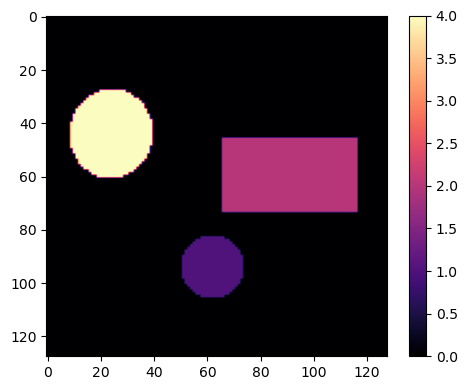

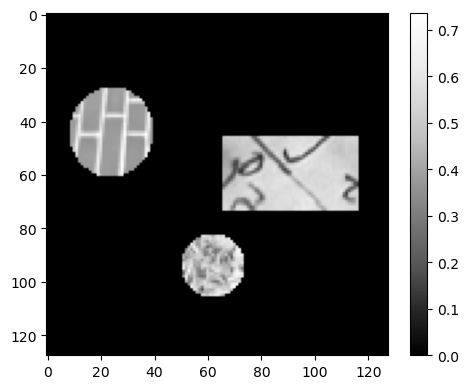

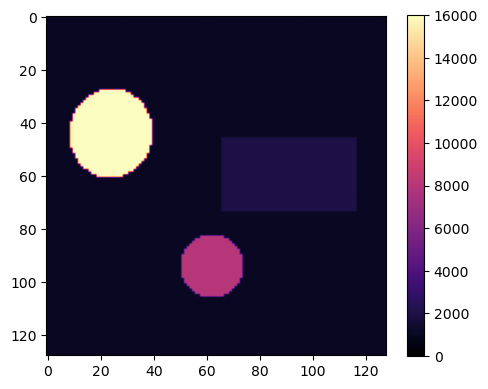

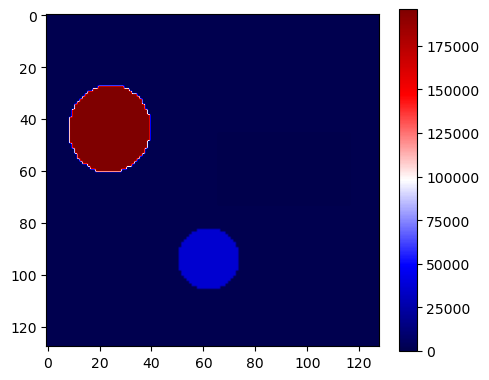

In [49]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(image, cmap='magma', vmin=0)
cbar = fig.colorbar(im)
fig.tight_layout()

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(texture, cmap='Greys_r')
cbar = fig.colorbar(im)
fig.tight_layout()

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(mu, cmap='magma', vmin=0)
cbar = fig.colorbar(im)
fig.tight_layout()

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(u, cmap='seismic')
cbar = fig.colorbar(im)
fig.tight_layout()